In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/flight-data.csv')
df.head()

,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,type,manufacturer,model,engines,seats,engine,arr_delay
0,B6,1201,N643JB,JFK,FLL,135.0,1069,21,50,73.04,66.92,81.14,160.0,13.80936,19.56326,0.0,1019.4,10.0,Fixed wing multi engine,AIRBUS,A320-232,2.0,200.0,Turbo-fan,1.0
1,DL,1773,N3743H,JFK,LAS,287.0,2248,15,35,71.06,42.98,36.28,230.0,14.96014,NaN,0.0,1020.4,10.0,Fixed wing multi engine,BOEING,737-832,2.0,189.0,Turbo-jet,0.0
2,EV,4572,N11107,EWR,GSP,84.0,594,15,9,78.80,69.80,73.95,200.0,8.05546,NaN,0.0,NaN,5.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2.0,55.0,Turbo-fan,1.0
3,B6,179,N526JB,JFK,PHX,305.0,2153,17,35,44.06,14.00,29.23,270.0,17.26170,24.16638,0.0,1009.2,10.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,US,1733,N162UW,LGA,CLT,78.0,544,7,53,69.98,53.96,56.78,230.0,6.90468,NaN,0.0,1021.3,10.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A321-211,2.0,199.0,Turbo-jet,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   carrier       10000 non-null  object 
 1   flight        10000 non-null  int64  
 2   tailnum       9926 non-null   object 
 3   origin        10000 non-null  object 
 4   dest          10000 non-null  object 
 5   air_time      9716 non-null   float64
 6   distance      10000 non-null  int64  
 7   hour          10000 non-null  int64  
 8   minute        10000 non-null  int64  
 9   temp          9952 non-null   float64
 10  dewp          9952 non-null   float64
 11  humid         9952 non-null   float64
 12  wind_dir      9731 non-null   float64
 13  wind_speed    9951 non-null   float64
 14  wind_gust     2387 non-null   float64
 15  precip        9954 non-null   float64
 16  pressure      8808 non-null   float64
 17  visib         9954 non-null   float64
 18  type          8499 non-null

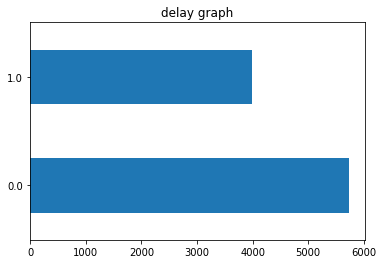

In [10]:
import matplotlib.pyplot as plt
df.arr_delay.value_counts().plot.barh()
plt.title('delay graph')
plt.show()

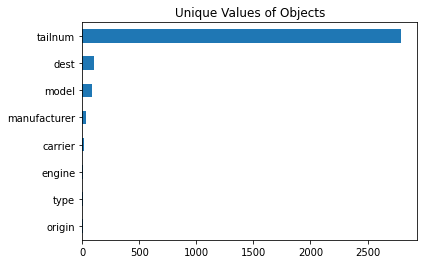

origin             3
type               3
engine             6
carrier           16
manufacturer      28
model             86
dest             101
tailnum         2795
dtype: int64

In [12]:
df.select_dtypes('object').nunique().sort_values().plot.barh()
plt.title('Unique Values of Objects')
plt.show()

df.select_dtypes('object').nunique().sort_values()

In [15]:
df.arr_delay.head()

0    1.0
1    0.0
2    1.0
3    1.0
4    0.0
Name: arr_delay, dtype: float64

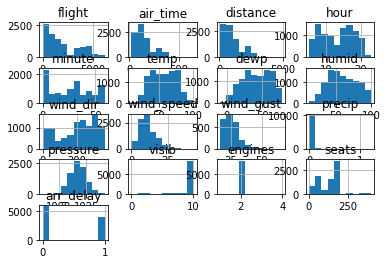

In [16]:
df.select_dtypes(['int64','float64']).hist()
plt.show()

In [51]:
df.isna().sum()

carrier            0
flight             0
tailnum           74
origin             0
dest               0
air_time           0
distance           0
hour               0
minute             0
temp               0
dewp               0
humid              0
wind_dir           0
wind_speed         0
wind_gust          0
precip             0
pressure           0
visib              0
type            1501
manufacturer    1501
model           1501
engines            0
seats              0
engine          1501
arr_delay          0
dtype: int64

In [55]:
df.dtypes

carrier          object
flight            int64
tailnum          object
origin           object
dest             object
air_time        float64
distance          int64
hour              int64
minute            int64
temp            float64
dewp            float64
humid           float64
wind_dir        float64
wind_speed      float64
wind_gust       float64
precip          float64
pressure        float64
visib           float64
type             object
manufacturer     object
model            object
engines         float64
seats           float64
engine           object
arr_delay       float64
dtype: object

In [59]:
df1=df.drop(columns=['carrier','tailnum','origin','dest','type','manufacturer','model','engine'])
df1.head(5)

,flight,air_time,distance,hour,minute,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,engines,seats,arr_delay
0,1201,135.0,1069,21,50,73.04,66.92,81.14,160.0,13.80936,19.56326,0.0,1019.400000,10.0,2.000000,200.00000,1.0
1,1773,287.0,2248,15,35,71.06,42.98,36.28,230.0,14.96014,25.29643,0.0,1020.400000,10.0,2.000000,189.00000,0.0
2,4572,84.0,594,15,9,78.80,69.80,73.95,200.0,8.05546,25.29643,0.0,1017.805722,5.0,2.000000,55.00000,1.0
3,179,305.0,2153,17,35,44.06,14.00,29.23,270.0,17.26170,24.16638,0.0,1009.200000,10.0,1.993293,135.89787,1.0
4,1733,78.0,544,7,53,69.98,53.96,56.78,230.0,6.90468,25.29643,0.0,1021.300000,10.0,2.000000,199.00000,0.0


In [63]:
df1.dtypes

flight          int64
air_time      float64
distance        int64
hour            int64
minute          int64
temp          float64
dewp          float64
humid         float64
wind_dir      float64
wind_speed    float64
wind_gust     float64
precip        float64
pressure      float64
visib         float64
engines       float64
seats         float64
arr_delay     float64
dtype: object

In [73]:
nums = df1.dtypes[df1.dtypes != 'object'].index.tolist()

cats = df1.dtypes[df1.dtypes == 'object'].index.tolist()
nums = [x for x in nums if x not in ['arr_delay']]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('impute_missing', SimpleImputer(missing_values = np.nan,strategy='median')),
                           ('standardize_num', StandardScaler())
                        ])

cat_pipeline = Pipeline([('impute_missing_cats', SimpleImputer(missing_values = np.nan,strategy='most_frequent')),
                          ('create_dummies_cats', OneHotEncoder())])

processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', num_pipeline, nums)])

print('Pipeline Created')

Pipeline Created


In [74]:
from sklearn.model_selection import train_test_split

y = df1.arr_delay 

tX_train, tX_test, ty_train, ty_test = train_test_split(df1[nums+cats],
                                                       y,
                                                       test_size=0.2
                                                       )

print(f'Training examples: {tX_train.shape[0]:,}')
print(f'Test examples: {tX_test.shape[0]:,}')

Training examples: 8,000
Test examples: 2,000


##**Logistic Regression**

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

p1 = Pipeline([('processing', processing_pipeline),
             ('lr', LogisticRegression(solver='liblinear'))])

params = {'lr__C': [0.01, 0.1, 1, 10]}

lr_gscv = GridSearchCV(p1, param_grid=params, cv=10, scoring='accuracy', refit=True)
lr_gscv = lr_gscv.fit(tX_train, ty_train)

print(f'Validation score: {lr_gscv.best_score_:.2%}')

lr_pred = lr_gscv.predict(tX_test)

print(f'Test score: {lr_gscv.score(tX_test, ty_test):.2%}')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unknown label type: 'continuous'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unknown label type: 'continuous'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unknown label type: 'continuous'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition f

ValueError: ignored

#**Decision Tree**

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

p2 = Pipeline([('processing', processing_pipeline),
             ('dt', DecisionTreeClassifier())])

params = {'dt__max_depth': [1, 5, 10, 15, 25],
         'dt__min_samples_split': [3, 10, 15]}

dt_gscv = GridSearchCV(p2, param_grid=params, cv=10, scoring='accuracy', refit=True)
dt_gscv = dt_gscv.fit(tX_train, ty_train)

print(f'Validation score: {dt_gscv.best_score_:.2%}')

dt_pred = dt_gscv.predict(tX_test)

print(f'Test score: {dt_gscv.score(tX_test, ty_test):.2%}')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `handle_unknown` must be 'error' when the drop parameter is specified, as both would create categories that are all zero.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `handle_unknown` must be 'error' when the drop parameter is specified, as both would create categories that are all zero.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `handle_unknown` must be 'error' when t

ValueError: ignored

#**Adaboost**

In [27]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# multi-step pipelines don't play as nice with AdaBoost
xt = processing_pipeline.fit_transform(tX_train)

params = {'base_estimator__max_depth': [1,2],
         'n_estimators': [50, 100, 200, 400]
         }

#ABC = AdaBoostClassifier(base_estimator=p2)
ABC = AdaBoostClassifier(DecisionTreeClassifier())


ad_gscv = GridSearchCV(ABC, param_grid = params, cv=10, scoring='accuracy')
           
ad_gscv = ad_gscv.fit(xt, ty_train)

print(f'Validation score: {ad_gscv.best_score_:.2%}')

xtt = processing_pipeline.transform(tX_test)

ad_pred = ad_gscv.predict(xtt)

print(f'Test score: {ad_gscv.score(xtt, ty_test):.2%}')

ValueError: ignored

#**Voting Classifier**

In [ ]:
from sklearn.ensemble import VotingClassifier

ems = [('lr', pipe1),('dt', pipe2),('knn', pipe3)]
clf4 = VotingClassifier(estimators= ems, weights=None, voting='soft')

scores = cross_val_score(estimator=clf4, X=X_train, y=y_train, cv=10, scoring='roc_auc')
print(f'ROC AUC {scores.mean():.2f} (+/- {scores.std():.2f}) [Ensemble]')